In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FinancialMachineLearning.features.concurrency import *
from FinancialMachineLearning.multiprocess import multiprocess

In [2]:
import os
os.chdir('..')
os.chdir('..')
os.getcwd()

'/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning'

In [3]:
dollar = pd.read_csv('./Data/dollar_bar.csv', index_col = 0, parse_dates = True)
dollar = dollar[~dollar.index.duplicated(keep = 'first')]
dollar

,open,high,low,close,volume
date_time,,,,,
2009-09-28 09:46:35,50.7900,51.0700,50.710,51.07,19844
2009-09-28 09:53:49,51.0700,51.1500,51.050,51.14,20324
2009-09-28 09:55:26,51.1400,51.1500,51.129,51.14,19622
2009-09-28 10:02:52,51.1400,51.2600,51.080,51.25,22319
2009-09-28 10:10:21,51.2500,51.2900,51.190,51.29,21519
...,...,...,...,...,...
2018-10-05 15:58:23,116.2425,116.2425,116.160,116.19,9647
2018-10-05 15:59:20,116.2000,116.2125,116.150,116.18,8821
2018-10-05 15:59:55,116.1800,116.2100,116.140,116.19,9196


#### Estimated Volatility

In [4]:
from FinancialMachineLearning.features.volatility import daily_volatility
vol = daily_volatility(dollar.close, lookback = 100)

#### CUSUM Filtering

In [5]:
from FinancialMachineLearning.filter.filter import cusum_filter
cusum_events = cusum_filter(dollar.close, threshold = vol.mean())

#### add Vertical barrier

In [6]:
from FinancialMachineLearning.labeling.labeling import *
vertical_barrier = add_vertical_barrier(cusum_events, dollar['close'], num_days = 1)

#### Triple Barrier Methods

In [7]:
triple_barrier_events = get_events(close = dollar['close'],
                                   t_events = cusum_events[23:],
                                   pt_sl = [1, 1],
                                   target = vol,
                                   min_ret = 0.01,
                                   num_threads = 1,
                                   vertical_barrier_times = vertical_barrier,
                                   side_prediction = None)
triple_barrier_events

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/labeling/labeling.py:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for loc, vertical_barrier in events_['t1'].fillna(close.index[-1]).iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


,t1,trgt,pt,sl
2009-10-02 09:32:42,2009-10-02 10:36:37,0.010414,1,1
2009-10-02 09:49:51,2009-10-05 09:35:27,0.010596,1,1
2009-10-02 10:02:18,2009-10-05 09:35:27,0.010649,1,1
2009-10-02 10:16:15,2009-10-05 09:35:27,0.010644,1,1
2009-10-02 10:22:23,2009-10-05 09:35:27,0.010550,1,1
...,...,...,...,...
2018-06-01 12:33:50,2018-06-04 09:30:00,0.010286,1,1
2018-06-01 13:07:55,2018-06-04 09:30:00,0.010231,1,1
2018-06-01 13:34:23,2018-06-04 09:30:00,0.010134,1,1
2018-06-01 14:05:37,2018-06-04 09:30:00,0.010091,1,1


#### Concurrency

In [8]:
num_threads = 1
num_conc_events = multiprocess.mp_pandas_obj(concurrent_events, ('molecule', triple_barrier_events.index), num_threads, close_series_index = dollar.close.index, label_endtime = triple_barrier_events['t1'])

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/concurrency.py:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t_in, t_out in label_endtime.iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:42: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:47: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


In [9]:
#num_conc_events = num_conc_events.loc[~num_conc_events.index.duplicated(keep = 'last')]

num_conc_events = num_conc_events.reindex(dollar.close.index).fillna(0)

In [10]:
num_conc_events

date_time
2009-09-28 09:46:35    0.0
2009-09-28 09:53:49    0.0
2009-09-28 09:55:26    0.0
2009-09-28 10:02:52    0.0
2009-09-28 10:10:21    0.0
                      ... 
2018-10-05 15:58:23    0.0
2018-10-05 15:59:20    0.0
2018-10-05 15:59:55    0.0
2018-10-05 15:59:59    0.0
2018-10-05 16:00:00    0.0
Length: 49996, dtype: float64

Text(0.5, 1.0, 'Label Concurrency versus EWMA Volatility')

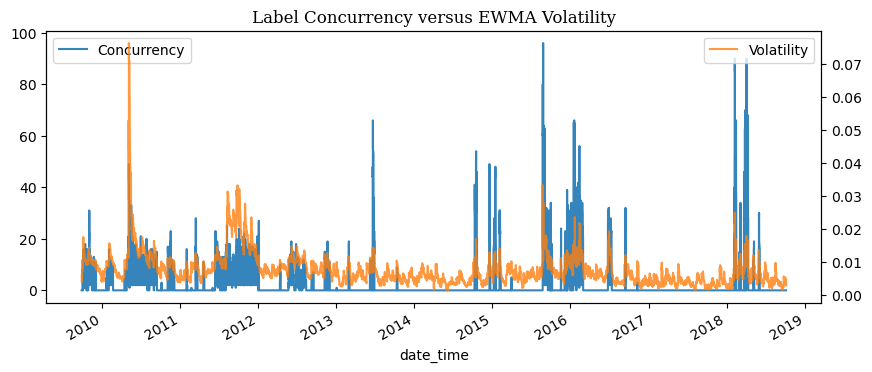

In [11]:
num_conc_events.plot(figsize = (10, 4), alpha = 0.9)
plt.legend(['Concurrency'])
vol.plot(secondary_y = True, alpha = 0.8)
plt.legend(['Volatility'])
plt.title('Label Concurrency versus EWMA Volatility', fontfamily = 'Serif', fontsize = 12)

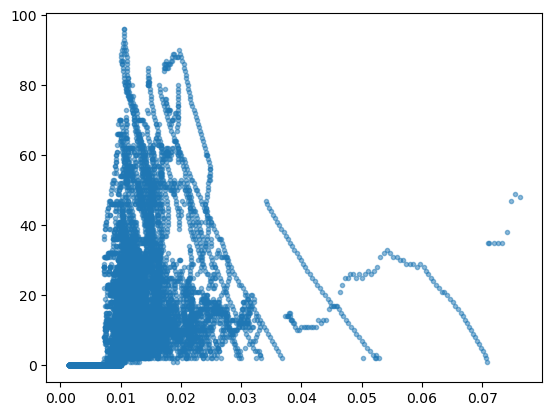

In [12]:
plt.scatter(vol, num_conc_events[27:], marker = '.', alpha = 0.5)

#### Uniqueness

In [13]:
avg_unique = multiprocess.mp_pandas_obj(average_uniqueness, ('molecule', triple_barrier_events.index), num_threads, 
                                 label_endtime = triple_barrier_events['t1'], num_conc_events = num_conc_events)
avg_unique

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/concurrency.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wght = pd.Series(index=molecule)
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/concurrency.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t_in, t_out in label_endtime.loc[wght.index].iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:42: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:47: F

2009-10-02 09:32:42    0.339732
2009-10-02 09:49:51    0.172768
2009-10-02 10:02:18    0.158540
2009-10-02 10:16:15    0.150595
2009-10-02 10:22:23    0.145862
                         ...   
2018-06-01 12:33:50    0.043347
2018-06-01 13:07:55    0.043754
2018-06-01 13:34:23    0.044955
2018-06-01 14:05:37    0.045676
2018-06-01 14:42:21    0.046756
Length: 8771, dtype: float64

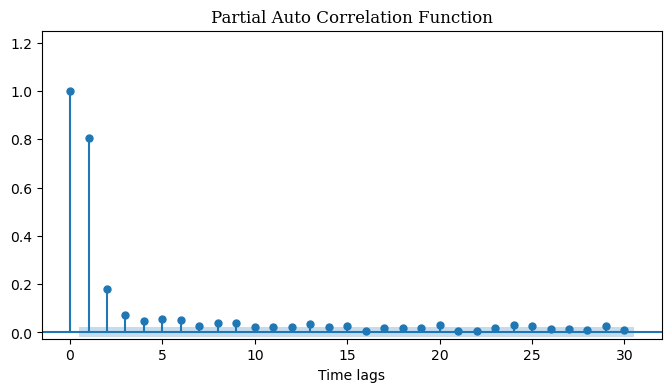

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(avg_unique, auto_ylims = True, lags = 30, ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial Auto Correlation Function', fontsize = 12, fontfamily = 'Serif')
plt.show()

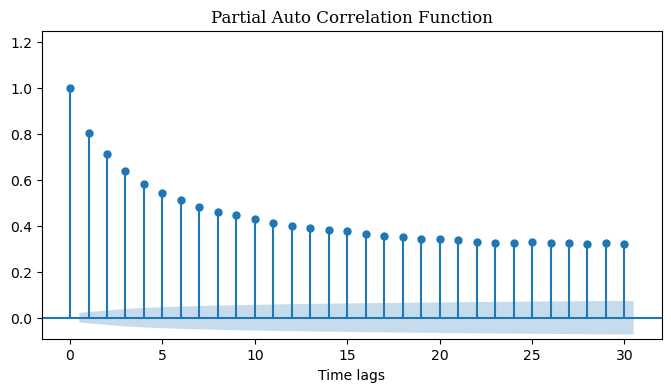

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(avg_unique, auto_ylims = True, lags = 30, ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial Auto Correlation Function', fontsize = 12, fontfamily = 'Serif')
plt.show()